#Introdução	à	Ciência	de	Dados - SME 0828

#Lista	de	exercícios	5
#Classificador Bayesiano

##Nome: João Victor Sene Araújo
##NUSP: 11796382

In [ ]:
import pandas as pd
import numpy as np
import random

from sklearn import metrics
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

import seaborn as sns # Biblioteca para mostrar os gráficos
sns.set()

###1 - Considerando a base de dados Vehicle, encontre o melhor classificador dentre os métodos k-vizinhos, Naive Bayes, regressão logística, classificador Bayesiano e classificador Bayesino não-paramétrico.

In [ ]:
data = pd.read_csv('data/Vehicle.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)

data.head(10)

,Comp,Circ,D.Circ,Rad.Ra,Pr.Axis.Ra,Max.L.Ra,Scat.Ra,Elong,Pr.Axis.Rect,Max.L.Rect,Sc.Var.Maxis,Sc.Var.maxis,Ra.Gyr,Skew.Maxis,Skew.maxis,Kurt.maxis,Kurt.Maxis,Holl.Ra,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
5,107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,bus
6,97,43,73,173,65,6,153,42,19,143,176,361,172,66,13,1,200,204,bus
7,90,43,66,157,65,9,137,48,18,146,162,281,164,67,3,3,193,202,van
8,86,34,62,140,61,7,122,54,17,127,141,223,112,64,2,14,200,208,van
9,93,44,98,197,62,11,183,36,22,146,202,505,152,64,4,14,195,204,saab


In [ ]:
print(classes)

['van' 'saab' 'bus' 'opel']


In [ ]:
# Transforma os dados para o numpy
datanp = data.to_numpy()
nrow,ncol = datanp.shape
y = datanp[:,-1]
X = datanp[:,0:ncol-1]

random.seed(5)

# Normalização
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
# Seleciona os conjuntos de treinamento e teste
p = 0.7 
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p)

In [ ]:
# Descobre qual o melhor valor de k para fazer a classificação:

nkf = 5 # Number of folds
vk = [] # Armazena os valores de k
vscore = []

for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    # Realiza a validação cruzada
    cv = cross_validate(model, x_train, y_train, cv=nkf)
    vscore.append(cv['test_score'].mean())
    vk.append(k)

best_k = np.argmax(vscore)+1 # Melhor número de vizinhos

# Ajusta o modelo k-vizinhos
model = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
model.fit(x_train,y_train)
# Faz a predição no conjunto de teste
y_pred = model.predict(x_test) 
# Verifica a acurácia da predição
score = accuracy_score(y_pred, y_test)

print('K-vizinhos:\n\tAcurácia: ', model.score(x_test, y_test))

K-vizinhos:
	Acurácia:  0.6771653543307087


In [ ]:
model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Naive Bayes:\n\tAcurácia: ', score)

Naive Bayes:
	Acurácia:  0.44881889763779526


In [ ]:
# Ajusta o modelo de Regressão Logistica
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 10000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Regressão Logística:\n\tAcurácia: ', model.score(x_test, y_test))

Regressão Logística:
	Acurácia:  0.7874015748031497


In [ ]:
P = pd.DataFrame(data=np.zeros((x_train.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe

for i in np.arange(0, len(classes)): # Para cada classe

    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    m = np.mean(Z, axis = 0) # Vetor media
    cv = np.cov(np.transpose(Z)) # Matriz de covariancia

    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        # calcula a probabilidade pertencer a cada classe
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas
for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred, dtype=str)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Classificador Bayseano:\n\tAcurácia: ', score)

Classificador Bayseano:
	Acurácia:  0.8740157480314961


In [ ]:
# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes)
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
h = 1

for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)

    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas

for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
    
y_pred = np.array(y_pred, dtype=str)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Classificador Bayseano não-paramétrico:\n\tAcurácia: ', score)

Classificador Bayseano não-paramétrico:
	Acurácia:  0.7165354330708661


Logo, para a dataframe Vehicle, o classificador Bayseano padrão apresentou a melhor acurácia.

###2 - Considerando a base de dados “winequality-red”, encontre o valor do hiperparâmetro h que oferece a maior acurácia no Bayesino não-paramétrico.

In [ ]:
random.seed(42) 

# data = pd.read_csv('data/winequality-red.csv', header=(0))
data = pd.read_csv('data/Vehicle.csv', header=(0))

classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)

data.head(10)

,Comp,Circ,D.Circ,Rad.Ra,Pr.Axis.Ra,Max.L.Ra,Scat.Ra,Elong,Pr.Axis.Rect,Max.L.Rect,Sc.Var.Maxis,Sc.Var.maxis,Ra.Gyr,Skew.Maxis,Skew.maxis,Kurt.maxis,Kurt.Maxis,Holl.Ra,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
5,107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,bus
6,97,43,73,173,65,6,153,42,19,143,176,361,172,66,13,1,200,204,bus
7,90,43,66,157,65,9,137,48,18,146,162,281,164,67,3,3,193,202,van
8,86,34,62,140,61,7,122,54,17,127,141,223,112,64,2,14,200,208,van
9,93,44,98,197,62,11,183,36,22,146,202,505,152,64,4,14,195,204,saab


In [ ]:
# Converte para matriz e vetor do numpy
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

# Transforma os dados para terem media igual a zero e variancia igual a 1
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Seleciona os conjuntos de treinamento e teste
p = 0.8 # fraction of elements in the test set
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

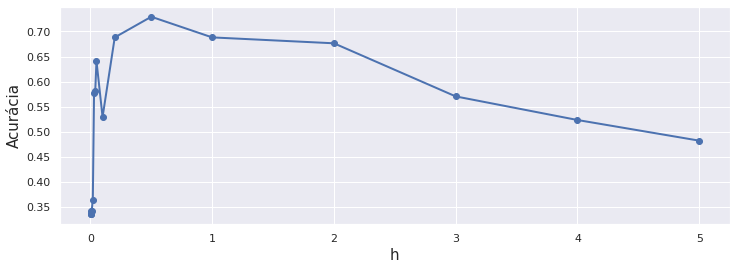

In [ ]:
####  Realiza a classificacao ####
vacc = []
vh = [0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.04, 0.05, 0.1, 0.2, 0.5, 1, 2,3,4, 5]
plt.figure(figsize=(12,4))
for h in vh:
    # Matriz que armazena as probabilidades para cada classe
    P = pd.DataFrame(data=np.zeros((x_train.shape[0], len(classes))), columns = classes) 
    Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
    for i in np.arange(0, len(classes)): # Para cada classe
        elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
        Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
        Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
        for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
            x = x_test[j,:]
            x = x.reshape((1,len(x)))
            # calcula a probabilidade pertencer a cada classe
            pj = np.exp(kde.score_samples(x)) 
            P[classes[i]][j] = pj*Pc[i]

    y_pred = [] # Vetor com as classes preditas
    for i in np.arange(0, x_test.shape[0]):
        c = np.argmax(np.array(P.iloc[[i]]))
        y_pred.append(classes[c])
    y_pred = np.array(y_pred, dtype=str)
    # calcula a acuracia
    score = accuracy_score(y_pred, y_test)
    vacc.append(score)
    
plt.plot(vh,vacc, 'o-', color = 'b', linewidth=2)
plt.xlabel('h', fontsize = 15)
plt.ylabel('Acurácia', fontsize = 15)
plt.show(True)

In [ ]:
index_best_h = np.argmax(vacc)

print("Melhor valor de h:",vh[index_best_h],"\n\tAcurácia:",vacc[index_best_h])

Melhor valor de h: 0.5 
	Acurácia: 0.7294117647058823


###3 - Faça a classificação dos dados gerados artificialmente com o código abaixo. Compare os resultados para os métodos Naive Bayes, Classificador Bayesiano paramétrico e o classificador Bayesiano não-paramétrico (escolha um valor para h).

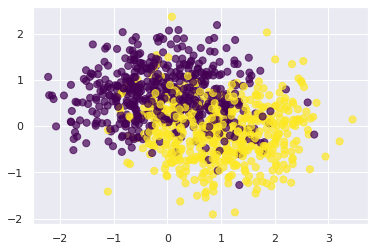

In [ ]:
plt.figure(figsize=(6,4))

n_samples = 1000

data = datasets.make_moons(n_samples=n_samples, noise=.5)

x = data[0]
y = data[1]

classes = np.array(pd.unique(y), dtype=int)

plt.scatter(x[:,0], x[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

In [ ]:
random.seed(5)

# Normalização
scaler = StandardScaler().fit(x)
x = scaler.transform(x)
# Seleciona os conjuntos de treinamento e teste
p = 0.7 
x_train, x_test, y_train, y_test = train_test_split( x, y, train_size = p)

In [ ]:
model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Naive Bayes:\n\tAcurácia: ', score)

Naive Bayes:
	Acurácia:  0.83


In [ ]:
P = pd.DataFrame(data=np.zeros((x_train.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe

for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elementos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    m = np.mean(Z, axis = 0) # Vetor media
    cv = np.cov(np.transpose(Z)) # Matriz de covariancia

    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        # calcula a probabilidade pertencer a cada classe
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas

for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])

y_pred = np.array(y_pred, dtype=int)

# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Classificador Bayseano:\n\tAcurácia: ', score)

Classificador Bayseano:
	Acurácia:  0.8433333333333334


In [ ]:
# Matriz que armazena as probabilidades para cada classe
P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) # Armaze a fracao de elementos em cada classe
h = 0.2

for i in np.arange(0, len(classes)): # Para cada classe
    elements = tuple(np.where(y_train == classes[i])) # elmentos na classe i
    Pc[i] = len(elements)/len(y_train) # Probabilidade pertencer a classe i
    Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)

    for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
        x = x_test[j,:]
        x = x.reshape((1,len(x)))
        # calcula a probabilidade pertencer a cada classe
        pj = np.exp(kde.score_samples(x)) 
        P[classes[i]][j] = pj*Pc[i]
        
y_pred = [] # Vetor com as classes preditas

for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])

y_pred = np.array(y_pred, dtype=int)
# calcula a acuracia
score = accuracy_score(y_pred, y_test)
print('Classificador Bayseano não-paramétrico:\n\tAcurácia: ', score)

Classificador Bayseano não-paramétrico:
	Acurácia:  0.83


Desse modo, é possível perceber que a acurácia entre os métodos de classificação apresentaram resultados muito semelhantes.